In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
import math
from datetime import datetime
import dateutil
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression

In [2]:
from coronavirus_mod_ita_test import *

In [3]:
sns.set(style="ticks")

In [4]:
__MOD_NAME = "ModReg_v9-test"
__SAVED_MOD_PATH = "saved_models/"
__PRED_DAYS = 50
__DATE_CURR = '2020-03-26'

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [38]:
def getModel(params):
    model = Model(rg=params['rg'],
                ra=params['ra'],
                alpha=params['alpha'],
                beta=params['beta'],
                beta_gcn=params['beta_gcn'],
                gamma=params['gamma'],
                t1=int(params['t1']),
                tgi2=int(params['tgi2']),
                tgn2=int(params['tgn2']),
                ta2=int(params['ta2']),
                Igs_t0=params['Igs_t0'],
                Igci_t0=0,
                Igcn_t0=0,
                Ias_t0=params['Ias_t0'],
                M_t0=0,
                Ggci_t0=0,
                Ggcn_t0=0,
                Gas_t0=0,
                rg_period=params['rg_period'],
                ra_period=params['ra_period'],
                Pop_tot=60000000
            )
    return model

In [72]:
def plotOptModLine(var_name, mod_data, label_val='', graph_option = None, steps=0):
    if graph_option is None:
        plt.plot((mod_data[var_name][0:steps]), label = label_val)
    else:
        plt.plot((mod_data[var_name][0:steps]), label = label_val, 
                 color = graph_option['color'],
                 linestyle = graph_option['linestyle'],
                 marker = graph_option['marker']
                )
        


def graphOptAll(mod_data, var_name_uff = None, steps=0):

    plt.figure(figsize = (10,7))
    plotOptModLine('dat_Igc_cum', mod_data, 'dat_Igc_cum', steps = steps)
    plotOptModLine('dat_Igc', mod_data, 'dat_Igc', steps = steps)
    #plotOptModLine('dat_Igci_t', opt_mod, optmod_name, 'dat_Igci_t', pred_days)
    plotOptModLine('dat_Gc_cum', mod_data, 'dat_Gc_cum', steps = steps)
    plotOptModLine('dat_Gc', mod_data, 'dat_Gc', steps = steps)
    plotOptModLine('dat_G', mod_data, 'dat_G', steps = steps)
    plotOptModLine('dat_M_cum', mod_data, 'dat_M_cum', steps = steps)
    plotOptModLine('dat_M', mod_data, 'dat_M', steps = steps)
    
    #plt.ylim((0,20000))
    plt.xlabel('giorni')
    plt.ylabel('n. persone')
    plt.title('Model curves')
    plt.legend()
    plt.show()
    
def graphParamSensVar(model, param_name, var_name, deltas = [0.1, 0.05], steps=0):
    graph_option = {'color': 'blue', 'linestyle': '-', 'marker': None}
    graph_option_min = [
        {'color': 'green', 'linestyle': '--', 'marker': None},
        {'color': 'red', 'linestyle': '--', 'marker': None}
    ]
    graph_option_max = [
        {'color': 'green', 'linestyle': '-.', 'marker': None},
        {'color': 'red', 'linestyle': '-.', 'marker': None}
    ]
    
    plt.figure(figsize = (10,7))
    mod_data = mod_dat(model)
    plotOptModLine(var_name, mod_data, var_name, steps = steps)
    
    param_sens_list = ['rg', 'ra', 'alpha', 'beta', 'beta_gcn', 'gamma', 't1', 'tgi2', 'tgn2', 'ta2', 'Igs_t0', 'Ias_t0', 'rg_period', 'ra_period']
    params = model.params.copy()
    param_val = model.params[param_name]
    for i, delta in enumerate(deltas):

        params['rg_period'] = model.rg_period
        params['ra_period'] = model.ra_period
        
        params[param_name] = param_val*(1 - delta)
        mod_min = getModel(params)
        mod_min.run(steps)
        mod_data_min = mod_dat(mod_min)
        
        params[param_name] = param_val*(1 + delta)
        mod_max = getModel(params)
        mod_max.run(steps)
        mod_data_max = mod_dat(mod_max)
        
        plotOptModLine(var_name, mod_data_min, var_name, steps = steps, graph_option = graph_option_min[i])
        plotOptModLine(var_name, mod_data_max, var_name, steps = steps, graph_option = graph_option_max[i])
        
    plt.xlabel('giorni')
    plt.ylabel('n. persone')
    plt.title('Parameter sensibility: %s' %(param_name))
    plt.legend()
    plt.show()
    
    
def graph(ax1, mod_data):
    ax1.plot((mod_data['dat_Igc_cum']))
    
def graphParamSensAll(model, param_name, deltas = [0.1, 0.05], steps=0):
    mod_data = mod_dat(model)
    fig = plt.figure(figsize = (20,14))
    #plt.figure(figsize = (10,7))
    ax1 = fig.add_subplot(321)
    graphParamSensVar(model, param_name, 'dat_Igc_cum', ax1, label_val = 'Igc_cum', deltas = deltas, steps=steps)
    ax1.legend()

    
    ax2 = fig.add_subplot(322)
    graphParamSensVar(model, param_name, 'dat_Igc', ax2, label_val = 'Igc', deltas = deltas, steps=steps)
    ax2.legend()
    
    ax3 = fig.add_subplot(323)
    graphParamSensVar(model, param_name, 'dat_Gc_cum', ax3, label_val = 'Gc_cum', deltas = deltas, steps=steps)
    ax3.legend()
    
    ax4 = fig.add_subplot(324)
    graphParamSensVar(model, param_name, 'dat_Gc', ax4, label_val = 'Gc', deltas = deltas, steps=steps)
    ax4.legend()
    
    ax5 = fig.add_subplot(325)
    graphParamSensVar(model, param_name, 'dat_M_cum', ax5, label_val = 'M_cum', deltas = deltas, steps=steps)
    ax5.legend()
    
    ax6 = fig.add_subplot(326)
    graphParamSensVar(model, param_name, 'dat_M', ax6, label_val = 'M', deltas = deltas, steps=steps)
    ax6.legend()
    
    fig.suptitle("Param Sensitivity: %s" %(param_name), fontsize=25, fontweight="bold", color="black") 
        #position=(0.5,1.01))

    #param_sens_list = ['rg', 'ra', 'alpha', 'beta', 'beta_gcn', 'gamma', 't1', 'tgi2', 'tgn2', 'ta2', 'Igs_t0', 'Ias_t0', 'rg_period', 'ra_period']
    var_list = ['dat_Igc_cum', 'dat_Igc', 'dat_Gc_cum', 'dat_Gc', 'dat_M_cum', 'dat_M']
    
            
def plotOptModLine2(var_name, mod_data, ax1, label_val='', graph_option = None, steps=0):
    
    if graph_option is None:
        ax1.plot((mod_data[var_name][0:steps]), label = label_val)
    else:
        ax1.plot((mod_data[var_name][0:steps]), label = label_val, 
                 color = graph_option['color'],
                 linestyle = graph_option['linestyle'],
                 marker = graph_option['marker']
                )
    
    
def graphParamSensVar(model, param_name, var_name, ax1, label_val = '', deltas = [0.1, 0.05], steps=0):
    graph_option = {'color': 'blue', 'linestyle': '-', 'marker': None}
    graph_option_min = [
        {'color': 'green', 'linestyle': '--', 'marker': None},
        {'color': 'red', 'linestyle': '--', 'marker': None}
    ]
    graph_option_max = [
        {'color': 'green', 'linestyle': '-.', 'marker': None},
        {'color': 'red', 'linestyle': '-.', 'marker': None}
    ]
    
    mod_data = mod_dat(model)
    params = model.params.copy()
    param_val = model.params[param_name]
    param_period = {'rg_period': model.params['rg'], 'ra_period': model.params['ra']}
    
    label_val_init = label_val + " (%.3f)" %(param_val) if param_name not in ['rg_period', 'ra_period'] else label_val + " (%.3f)" %(param_period[param_name])
    plotOptModLine2(var_name, mod_data, ax1, label_val = label_val_init, steps = steps)
    
    time_params = ['t1', 'tgi2', 'tgn2', 'ta2']
    for i, delta in enumerate(deltas):
        params['rg_period'] = model.rg_period
        params['ra_period'] = model.ra_period
        if param_name in time_params:
            time_factor = 3
            param_min = max(2, param_val - time_factor*(i+1)) 
            param_max = param_val + time_factor*(i+1)
        elif param_name in ['Igs_t0', 'Ias_t0']:
            start_cond_factor = 50
            param_min = max(2, param_val - start_cond_factor*(i+1)) 
            param_max = param_val + start_cond_factor*(i+1)
        elif param_name in ['rg_period', 'ra_period']:
            param_min = [param_period[param_name]*(1-delta)**(math.floor(x/7)) for x in range(0,steps)]
            param_max = [param_period[param_name]*(1+delta)**(math.floor(x/7)) for x in range(0,steps)]
        else:
            param_min = param_val*(1 - delta)
            param_max = param_val*(1 + delta)
            
        params[param_name] = param_min
        mod_min = getModel(params)
        mod_min.run(steps)
        mod_data_min = mod_dat(mod_min)
        
        
        params[param_name] = param_max
        mod_max = getModel(params)
        mod_max.run(steps)
        mod_data_max = mod_dat(mod_max)
        
        label_val_min = label_val + " (%.3f)" %(param_min) if param_name not in ['rg_period', 'ra_period'] else label_val + " (%.3f)" %(param_min[14])
        label_val_max = label_val + " (%.3f)" %(param_max) if param_name not in ['rg_period', 'ra_period'] else label_val + " (%.3f)" %(param_max[14])
        plotOptModLine2(var_name, mod_data_min, ax1, label_val=label_val_min, steps = steps, graph_option = graph_option_min[i])
        plotOptModLine2(var_name, mod_data_max, ax1, label_val=label_val_max, steps = steps, graph_option = graph_option_max[i])




In [73]:
[math.floor(x/7) for x in range(0, 22)]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3]

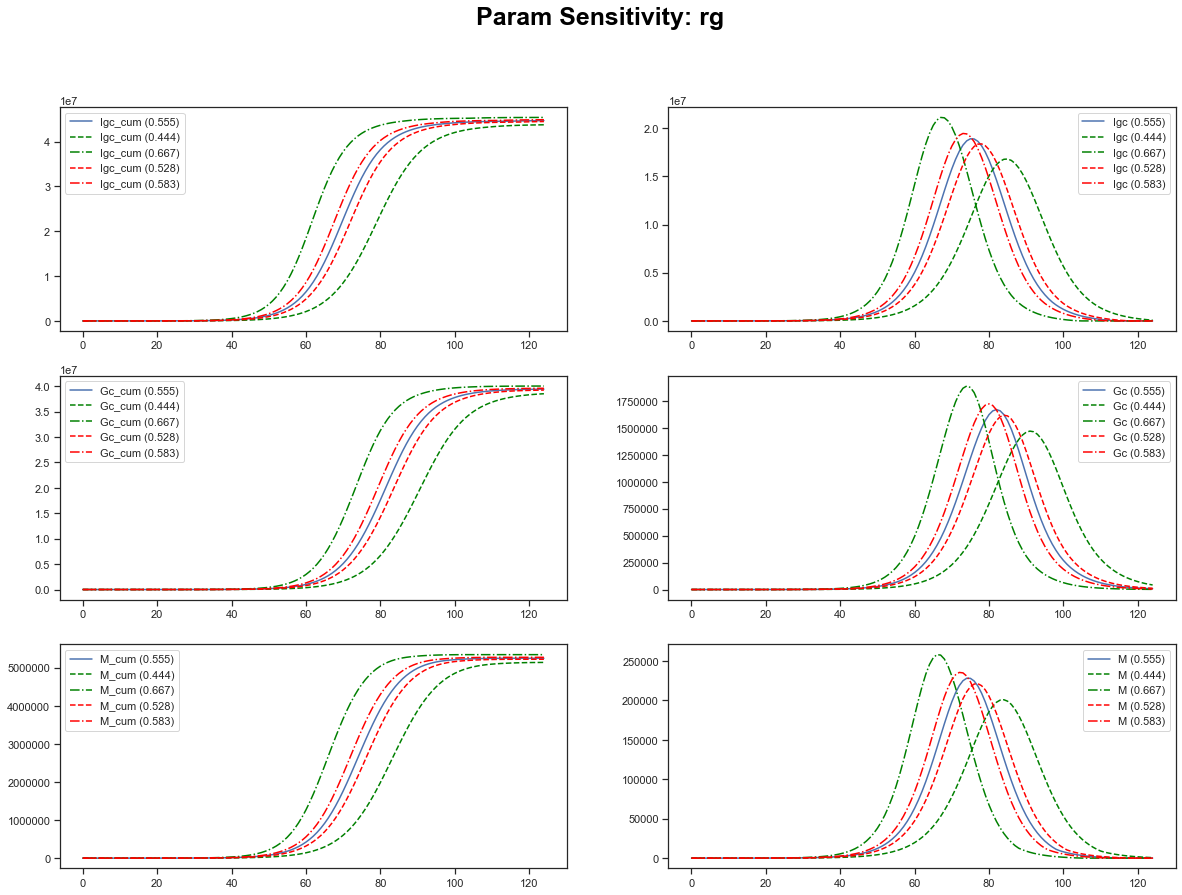

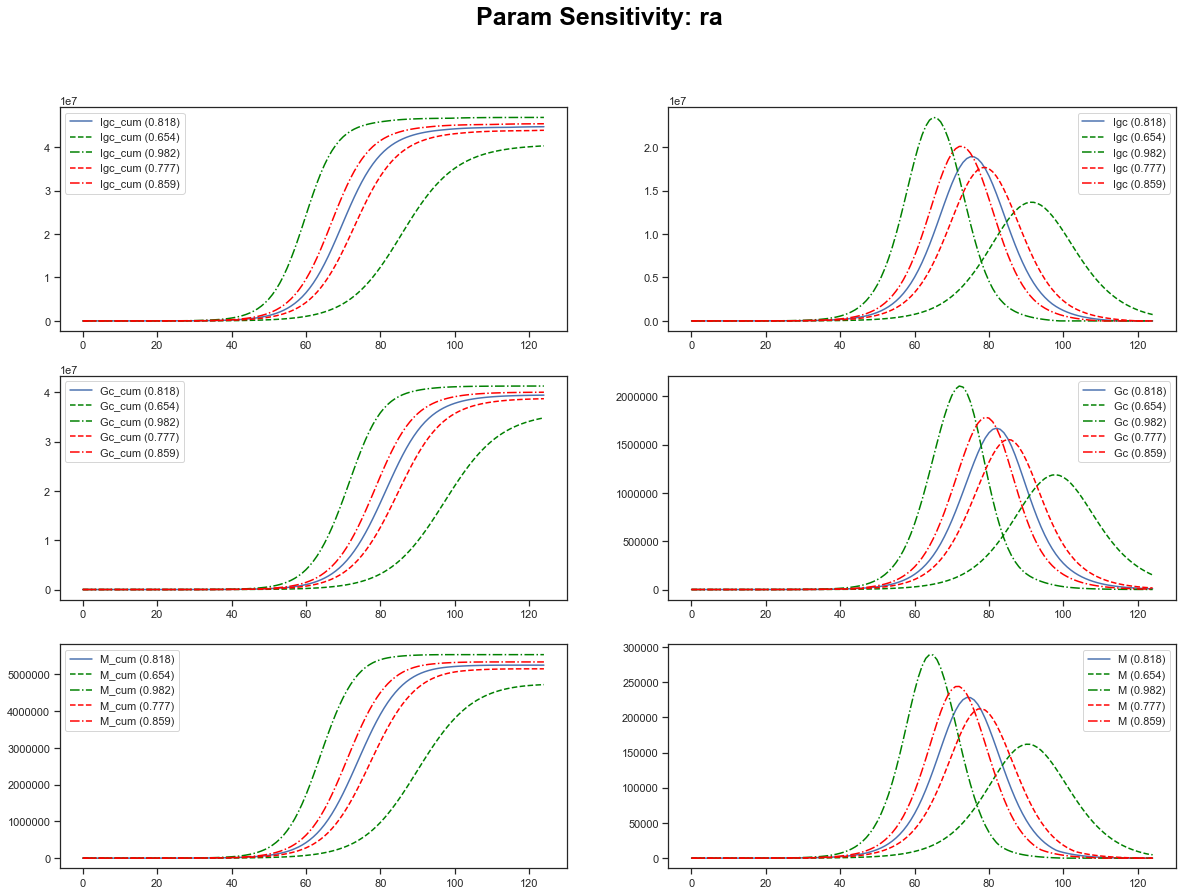

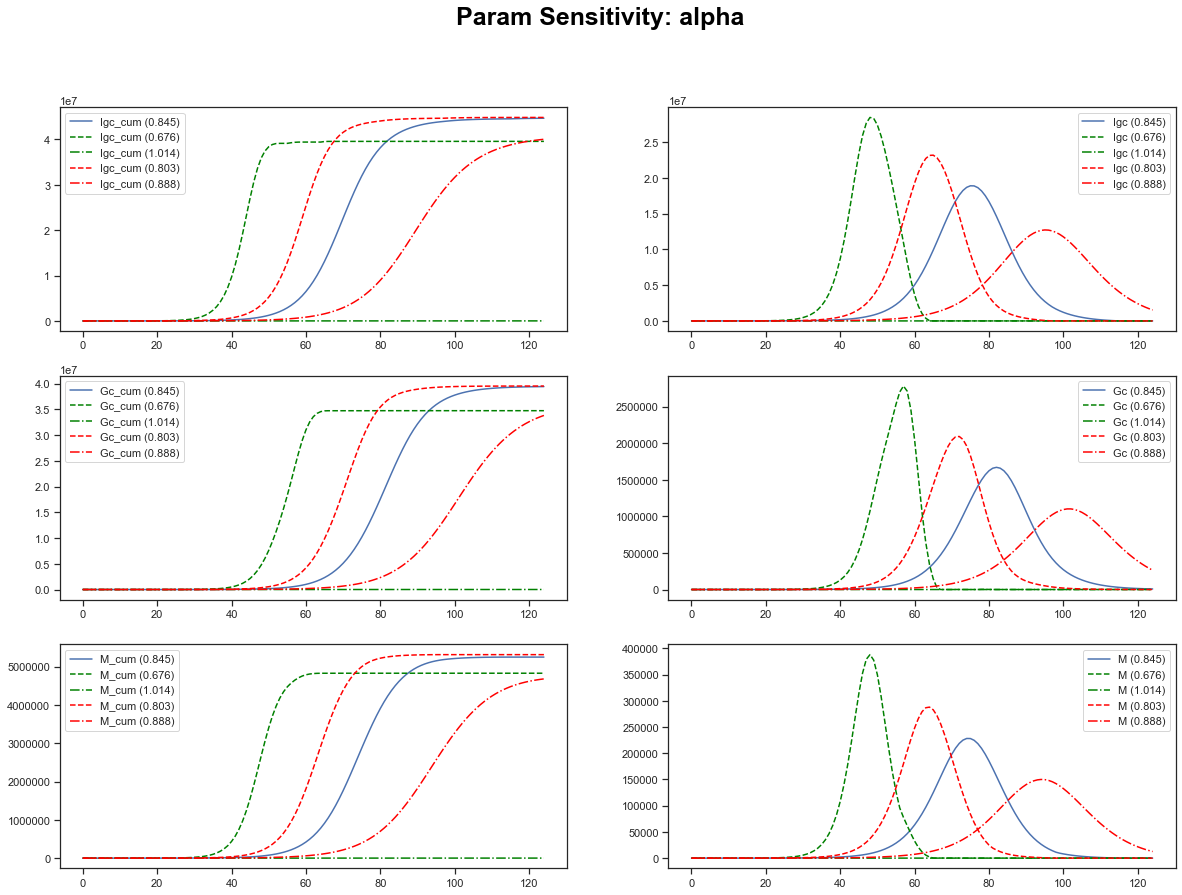

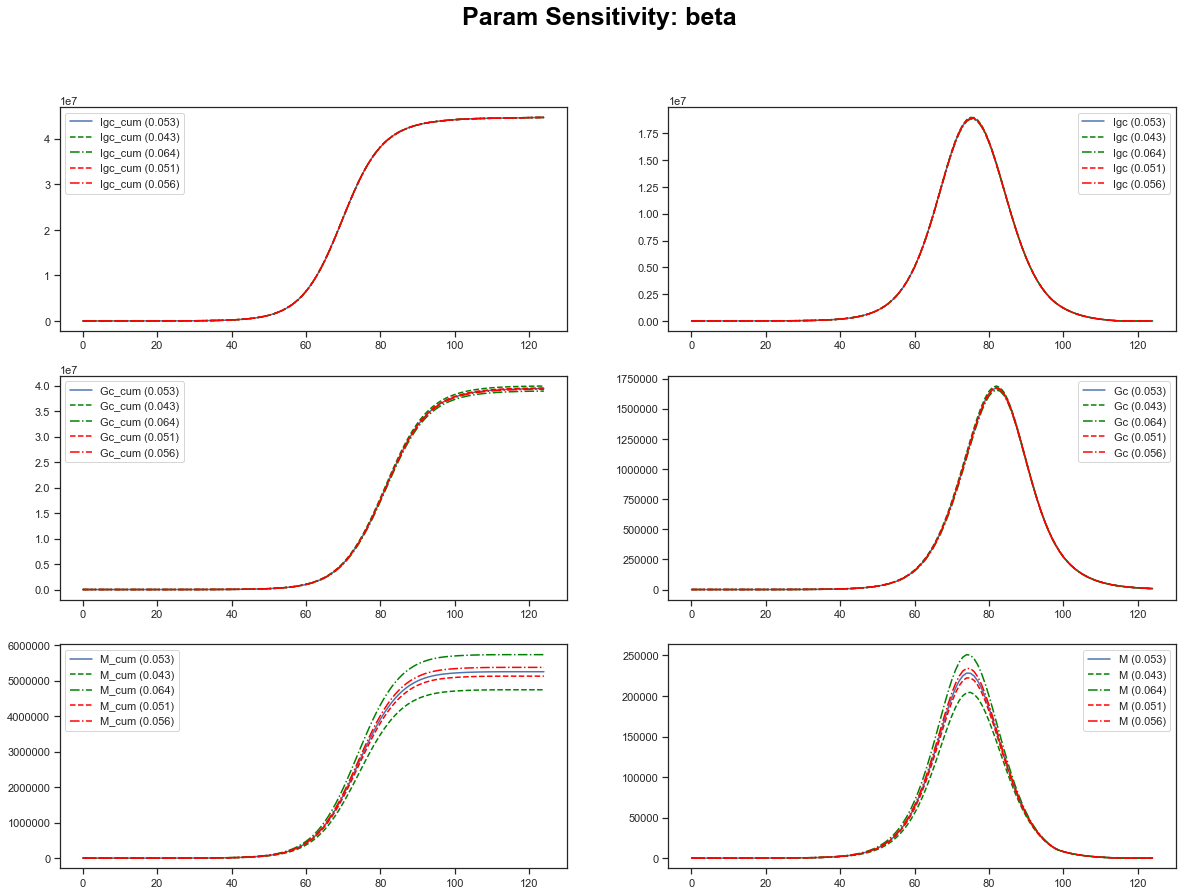

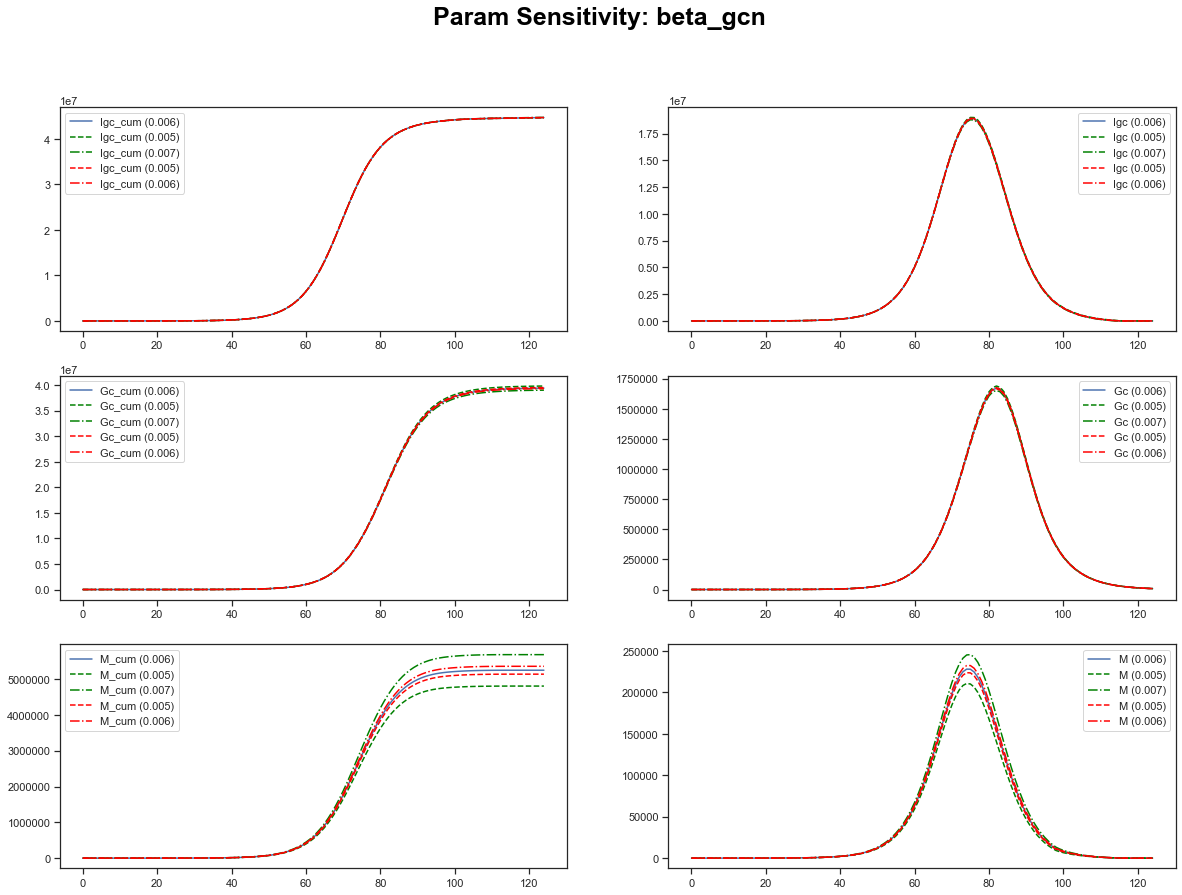

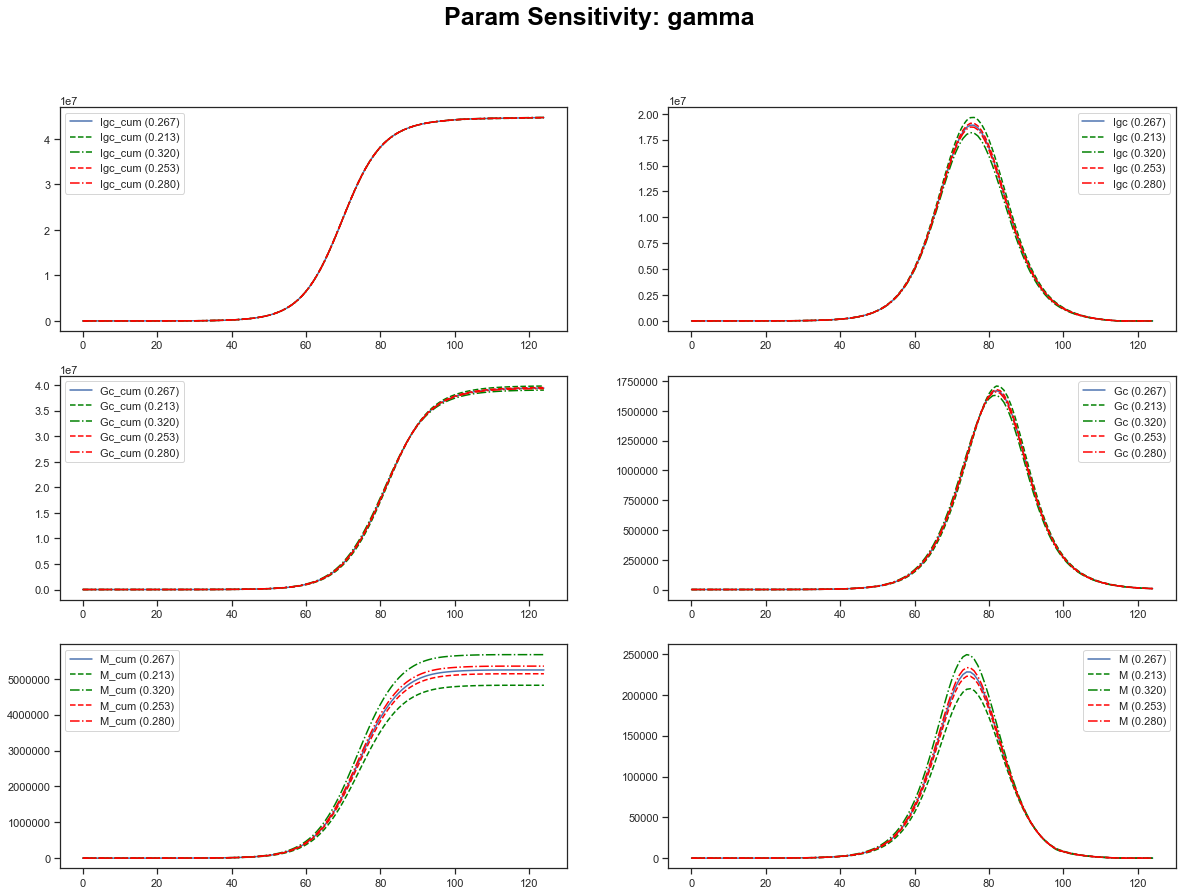

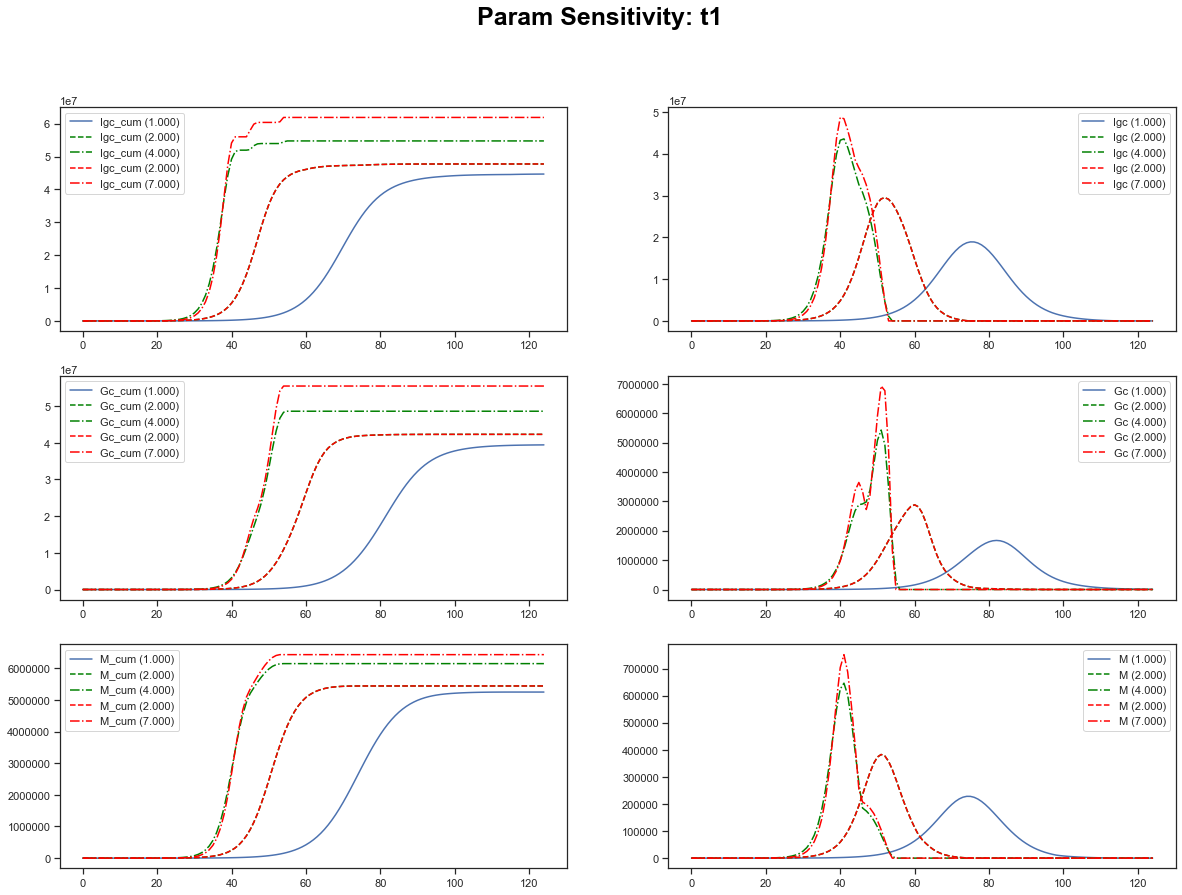

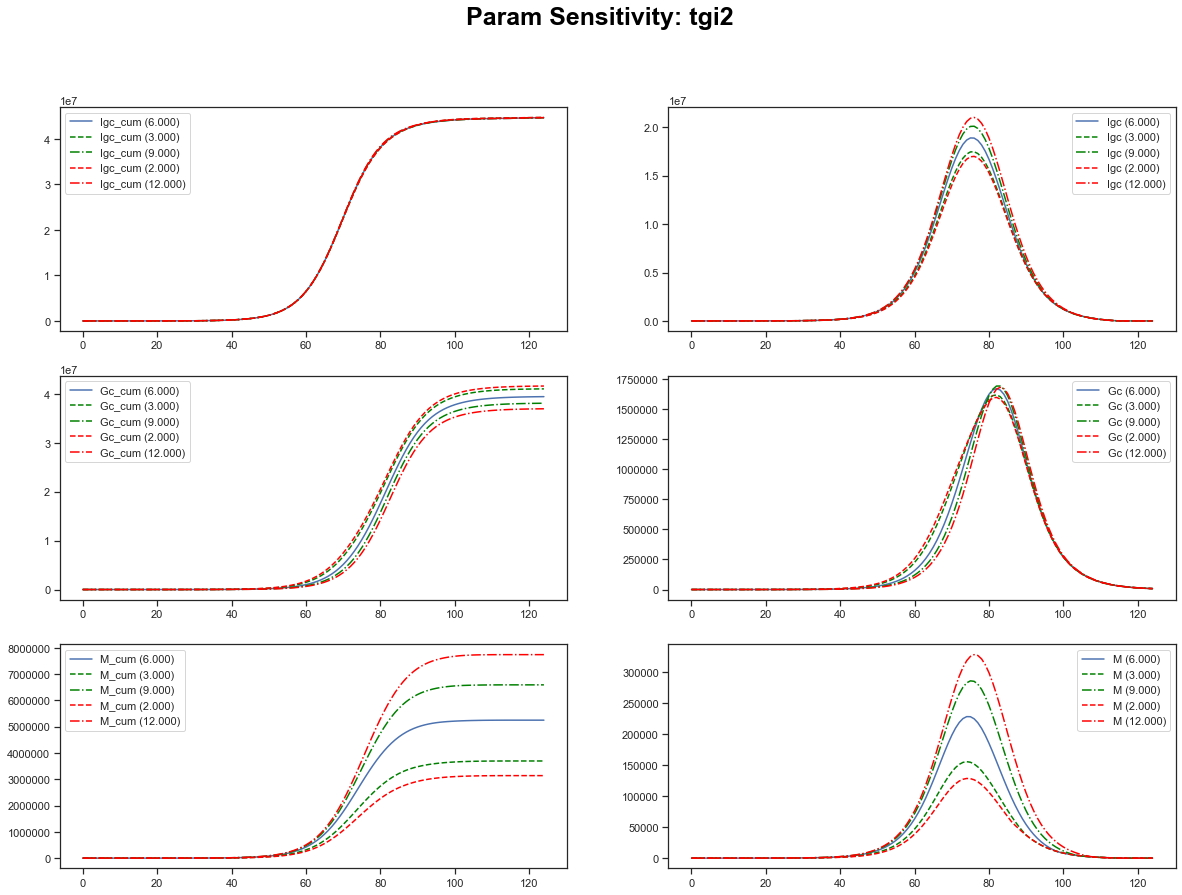

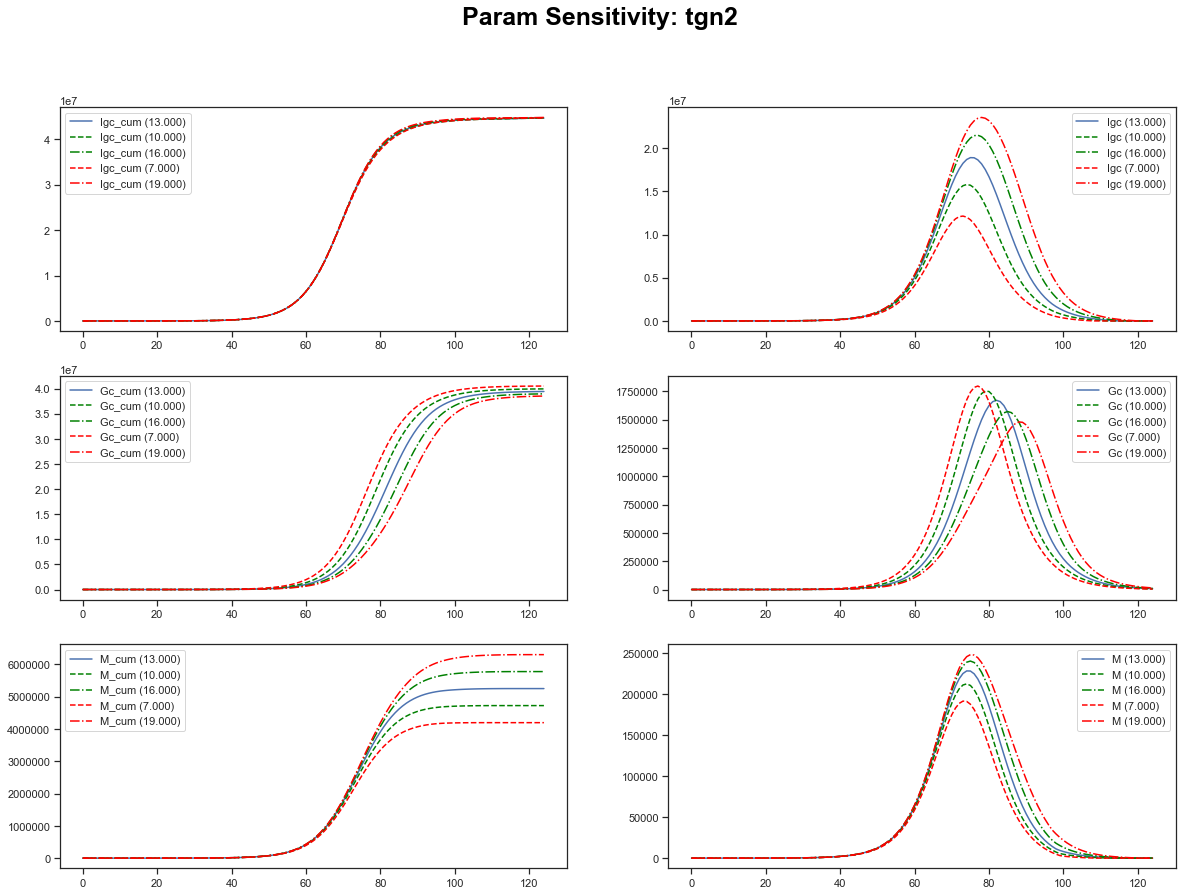

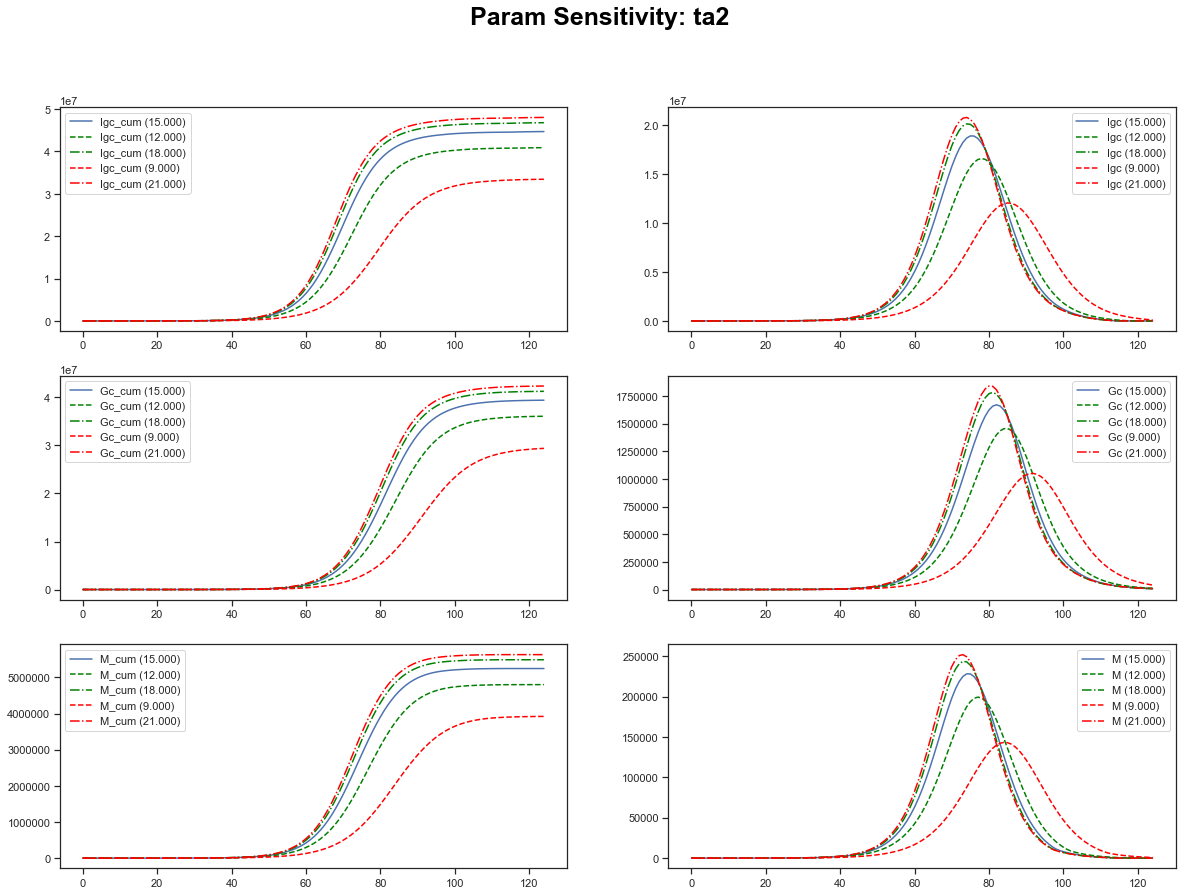

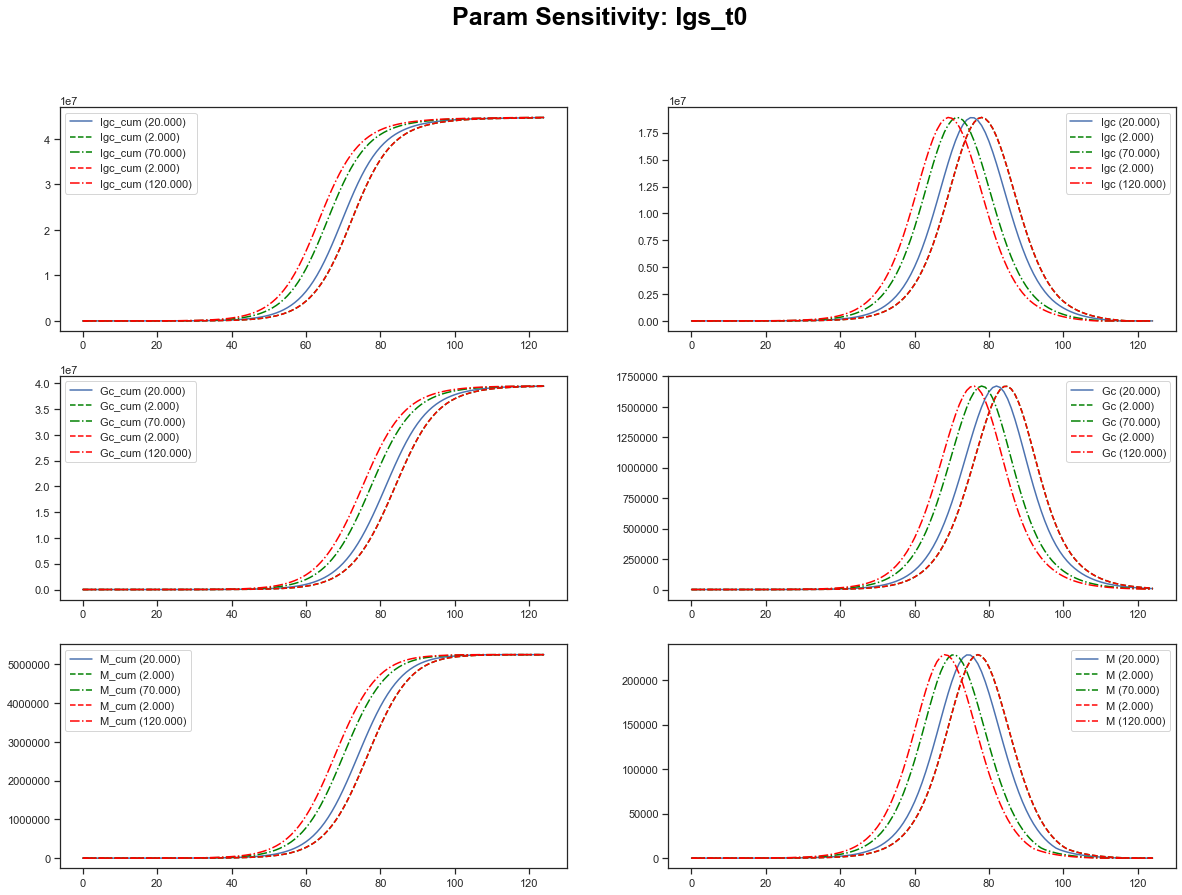

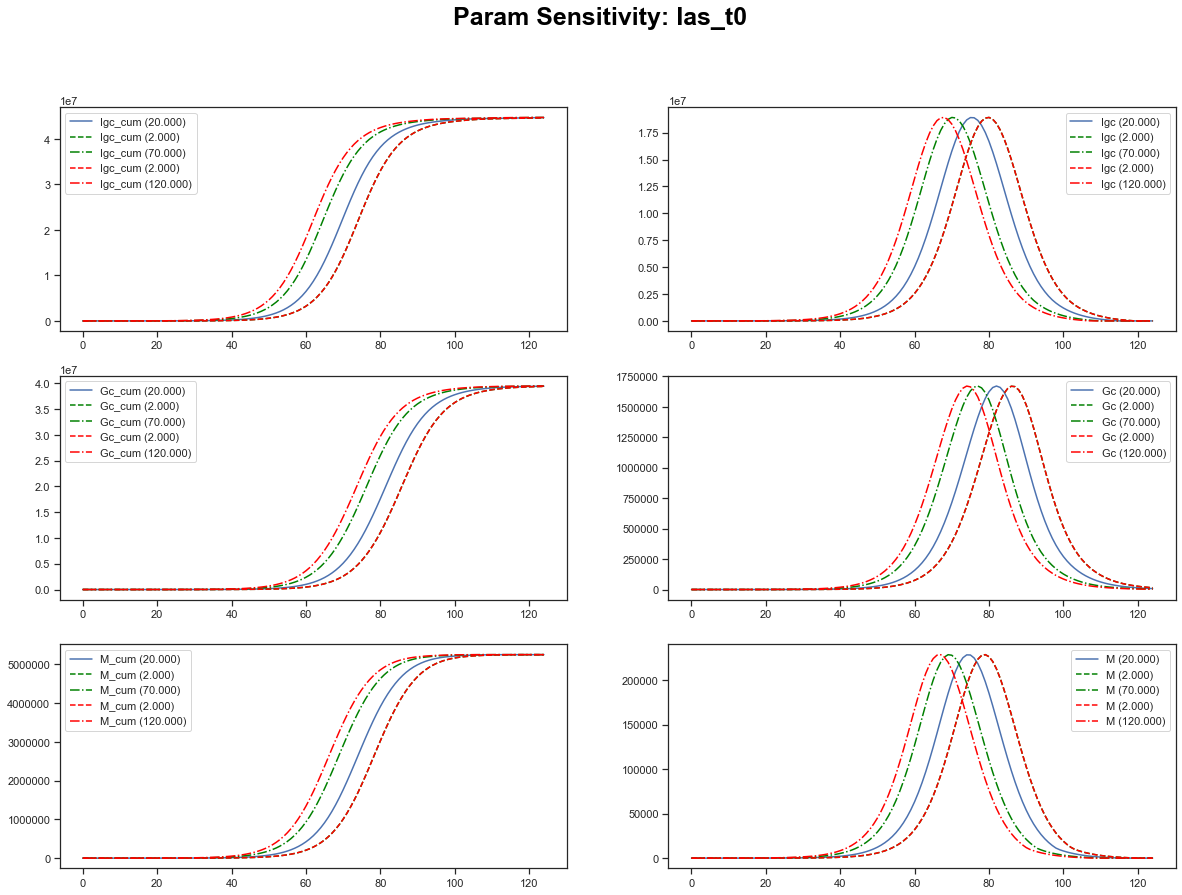

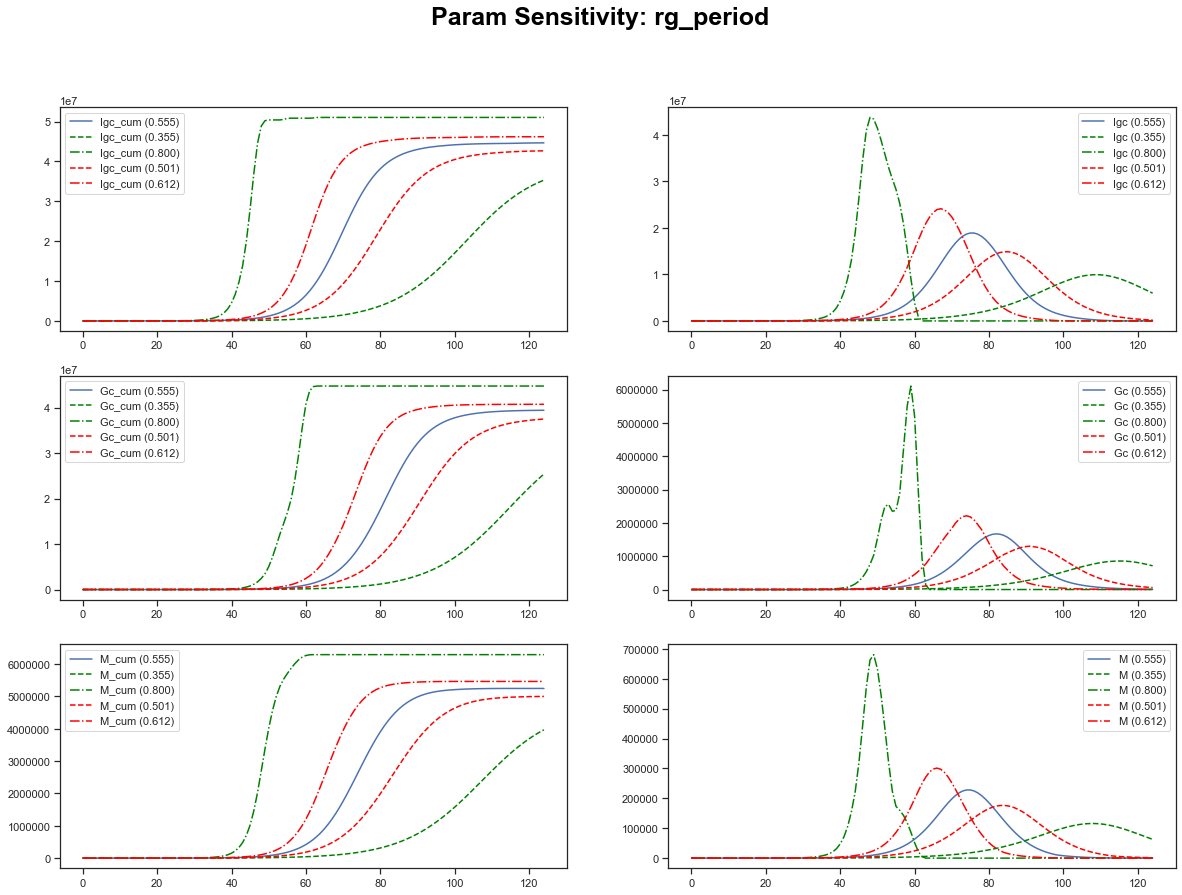

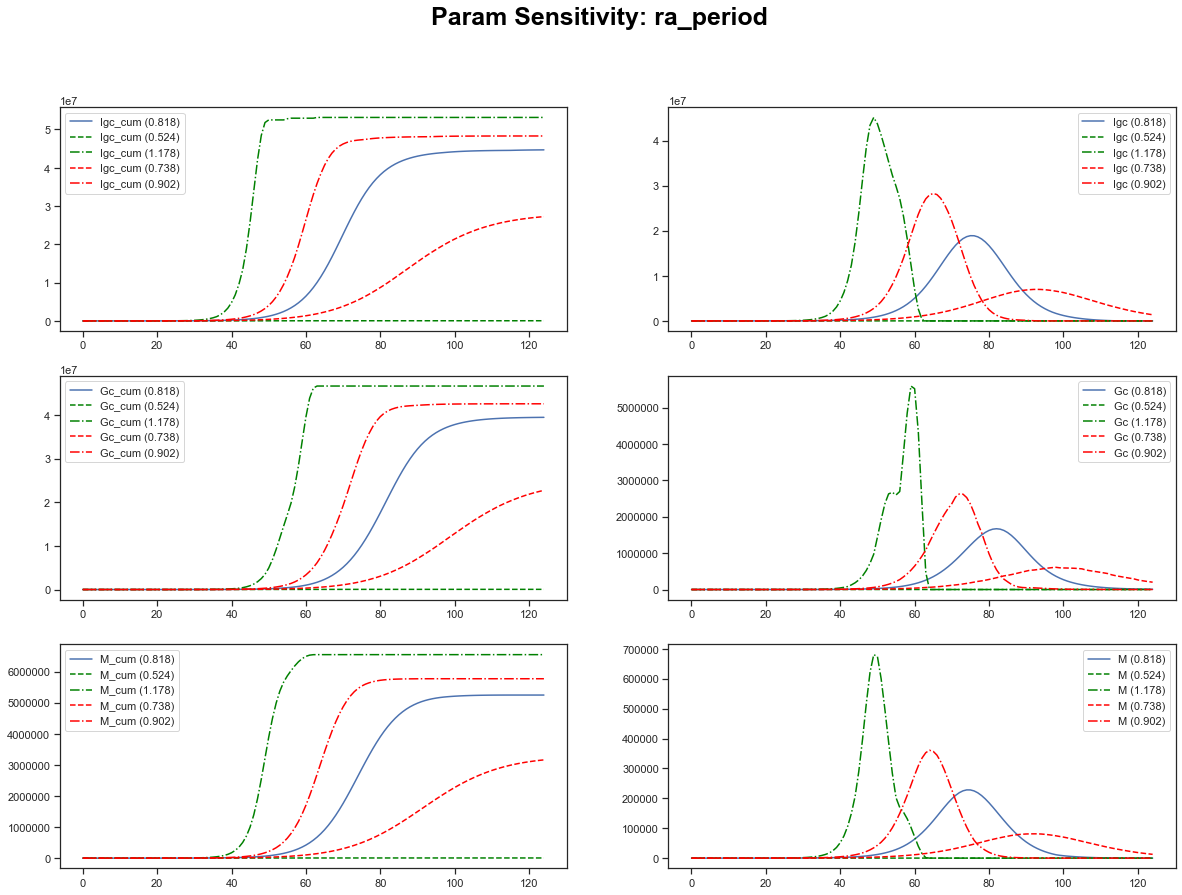

In [74]:
deltas = [0.2, 0.05]
param_sens_list = ['rg', 'ra', 'alpha', 'beta', 'beta_gcn', 'gamma', 't1', 'tgi2', 'tgn2', 'ta2', 'Igs_t0', 'Ias_t0', 'rg_period', 'ra_period']
for param in param_sens_list:
    graphParamSensAll(mod_, param, deltas = deltas, steps=125)

In [8]:
model_stepsforward = 200
mod_ = Model(rg=0.555444,
            ra=0.818018,
            alpha=0.845285,
            beta=0.053366,
            beta_gcn=0.005667,
            gamma=0.266832,
            t1=1,
            tgi2=6,
            tgn2=13,
            ta2=15,
            Igs_t0=20,
            Igci_t0=0,
            Igcn_t0=0,
            Ias_t0=20,
            M_t0=0,
            Ggci_t0=0,
            Ggcn_t0=0,
            Gas_t0=0,
            rg_period=None,
            ra_period=None,
            Pop_tot=60000000
           )

mod_.run(model_stepsforward)
mod_data = mod_dat(mod_)

In [ ]:
graphOptAll(mod_data, var_name_uff = 'dat_Igc_cum', steps=125)

In [ ]:


graphParamSensibility(mod_, 'rg', 'dat_Igc_cum', deltas = [0.1, 0.05], steps=125)

In [ ]:
%matplotlib inline

In [ ]:
def pl(ax1):
    ax1.text(0.5, 0.5, str((2,3,i)))

fig = plt.figure()
#fig.subplots_adjus
for i in range(1, 5):
    ax = fig.add_subplot(2,2,i)
    pl(ax)